In [1]:
import os
import sys
import numpy as np
import pandas as pd
from math import sqrt
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

path = os.getcwd()
os.chdir(path[:path.find("Estatística Básica")])

In [2]:
df = pd.read_csv(os.path.abspath("data/tabela2_1.csv"), sep=";", index_col="N")
df["Salario (x Sal Min)"] = df["Salario (x Sal Min)"].str.replace(",", ".").astype(float)


In [3]:
df.head()

,Estado Civil,Grau de Instrução,N de Filhos,Salario (x Sal Min),Anos,Meses,Região de Procedência
N,,,,,,,
1,solteiro,ensino fundamental,NaN,4.00,26,3,interior
2,casado,ensino fundamental,1.0,4.56,32,10,capital
3,casado,ensino fundamental,2.0,5.25,36,5,capital
4,solteiro,ensino médio,NaN,5.73,20,10,outra
5,solteiro,ensino fundamental,NaN,6.26,40,7,outra


# Análise Bidimensional

## Variáveis Qualitativas

In [4]:
df_pivot = pd.pivot_table(
    df[['Região de Procedência', 'Grau de Instrução']], 
    index="Região de Procedência",
    columns="Grau de Instrução", 
    aggfunc=lambda x: int(round(len(x) / len(df) * 100, 0)),
    margins=True,
    margins_name="Total",
)
df_pivot

Grau de Instrução,ensino fundamental,ensino médio,superior,Total
Região de Procedência,,,,
capital,11,14,6,31
interior,8,19,6,33
outra,14,17,6,36
Total,33,50,17,100


In [5]:
joint_df = (pd.crosstab(index=df["Região de Procedência"],
                       columns=df["Grau de Instrução"],
                       normalize="columns") * 100).round(0).astype(int)
joint_df.loc["Total"] = joint_df.sum()


<Axes: xlabel='Grau de Instrução'>

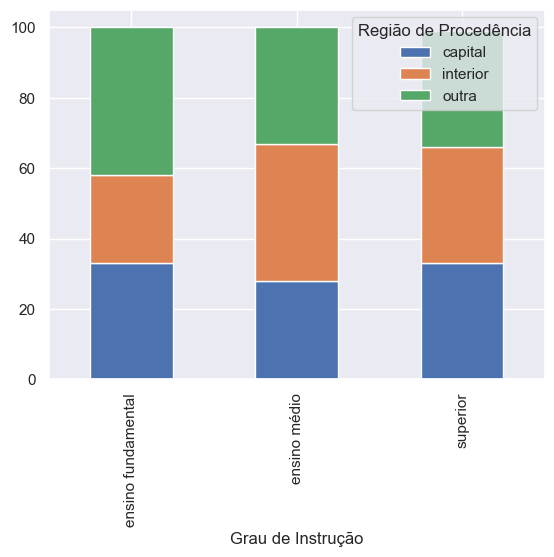

In [6]:
sns.set()
joint_df.iloc[:3].T.plot(kind='bar', stacked=True)


In [7]:
states = ["São Paulo", "Paraná", "Rio Grande do Sul"]
customers = [214, 51, 111]
products = [237, 102, 304]
school = [78, 126, 139]
others = [119, 22, 48]

df = pd.DataFrame(
    {
        "Estados": states,
        "Consumidor": customers,
        "Produtor": products,
        "Escola": school,
        "Outros": others
    }
)
df = df.set_index("Estados")
df_with_total = df.copy()
df_with_total.loc["Total"] = df_with_total.sum()
df_with_total["Total"] = df_with_total.sum(axis=1)

In [8]:
df_percents = (df_with_total.div(df_with_total["Total"], axis=0) * 100)
df_percents = df_percents.round(2)
df_percents

,Consumidor,Produtor,Escola,Outros,Total
Estados,,,,,
São Paulo,33.02,36.57,12.04,18.36,100.0
Paraná,16.94,33.89,41.86,7.31,100.0
Rio Grande do Sul,18.44,50.50,23.09,7.97,100.0
Total,24.24,41.46,22.11,12.19,100.0


In [9]:
df_espected = pd.DataFrame(
    {
        "Estados": states,
        "Consumidor": list(((df_percents.loc["Total", "Consumidor"] / 100) * df_with_total.loc[:, "Total"]).values)[:len(states)],
        "Produtor": list(((df_percents.loc["Total", "Produtor"] / 100) * df_with_total.loc[:, "Total"]).values)[:len(states)],
        "Escola": list(((df_percents.loc["Total", "Escola"] / 100) * df_with_total.loc[:, "Total"]).values)[:len(states)],
        "Outros": list(((df_percents.loc["Total", "Outros"] / 100) * df_with_total.loc[:, "Total"]).values)[:len(states)],
    }
)
df_espected = df_espected.set_index("Estados")
df_espected = df_espected.round(0).astype(int)
df_espected

,Consumidor,Produtor,Escola,Outros
Estados,,,,
São Paulo,157,269,143,79
Paraná,73,125,67,37
Rio Grande do Sul,146,250,133,73


In [10]:
df_desv = (df - df_espected).round(0).astype(int)
df_desv

,Consumidor,Produtor,Escola,Outros
Estados,,,,
São Paulo,57,-32,-65,40
Paraná,-22,-23,59,-15
Rio Grande do Sul,-35,54,6,-25


$$ \frac{(o_i - e_i)^2}{e_i} $$

In [11]:
sao_paulo_escole_qui_quadrado = ((df.loc["São Paulo", "Escola"] - df_espected.loc["São Paulo", "Escola"]) ** 2) / df_espected.loc["São Paulo", "Escola"]
sao_paulo_escole_qui_quadrado

29.545454545454547

Qui Quadrado

$$ \chi^2 = \sum_{i=1}^r \sum_{j=1}^s \frac{(n_{ij}-n_{ij}^*)^2}{n_{ij}^*} $$

In [12]:
r = df.shape[0]
c = df.shape[1]
n = df_with_total.loc["Total", "Total"]
qui_quadrado = ((df - df_espected) ** 2 / df_espected).sum().sum()
qui_quadrado

172.0847515023836

Coeficiente de Contingência

$$ C = \sqrt{\frac{\chi^2}{\chi^2 + n}} $$

In [13]:
C = sqrt(qui_quadrado / (qui_quadrado + n))
C

0.3160224058082541

Coeficiente Tschuprow

$$ T = \sqrt{\frac{\chi^2}{n\sqrt{(r-1)(s-1)}}} $$

In [14]:
T = sqrt(qui_quadrado / (n * sqrt((r - 1) * (c - 1))))
T

0.21282737230781038

Coeficiente de Crâmer

$$ V = \sqrt{\frac{\chi^2}{n \times \min{((r-1), (c-1))}}} $$

Sendo **r** o número de linhas (variável independente) e **c** o número de colunas (variável dependente).

In [15]:
V = sqrt(qui_quadrado / (n * (min(r-1, c-1))))
V

0.23553220495038263

## Variáveis Quantitativas

In [4]:
agentes = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
ano_servico = [2, 3, 4, 5, 4, 6, 7, 8, 8, 10]
num_clientes = [48, 50, 56, 52, 43, 60, 62, 58, 64, 72]

df = pd.DataFrame(
    {
        "Agentes": agentes,
        "Anos de Serviço": ano_servico,
        "Número de Clientes": num_clientes
    }
)
df = df.set_index("Agentes")
df

,Anos de Serviço,Número de Clientes
Agentes,,
A,2,48
B,3,50
C,4,56
D,5,52
E,4,43
F,6,60
G,7,62
H,8,58
I,8,64


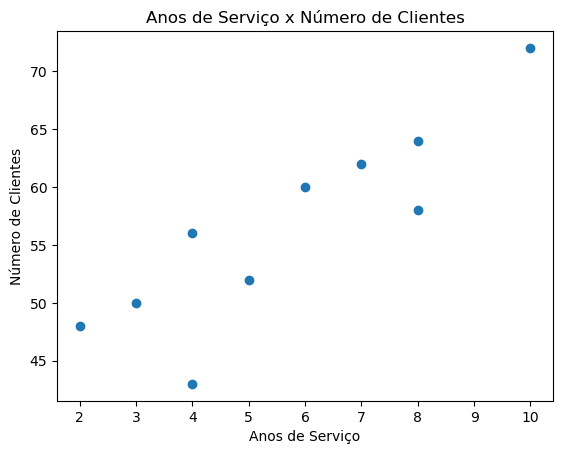

In [5]:

plt.scatter(df["Anos de Serviço"], df["Número de Clientes"])
plt.title("Anos de Serviço x Número de Clientes")
plt.xlabel("Anos de Serviço")
plt.ylabel("Número de Clientes")
plt.show()

Numa pesquisa feita com dez famílias com renda bruta mensal entre 10 e 60 salários mínimos, mediram-se a porcentagem da renda bruta anual gasta com assistência médica.

In [18]:
familia = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
renda = [12, 16, 18, 20, 28, 30, 40, 48, 50, 54]
gasto_medico = [7.2, 7.4, 7.0, 6.5, 6.6, 6.7, 6.0, 5.6, 6.0, 5.5]

df = pd.DataFrame(
    {
        "Família": familia,
        "Renda Bruta Mensal (Sal Min)": renda,
        "Gasto Médico Anual (% Anual)": gasto_medico
    }
)
df = df.set_index("Família")
df

,Renda Bruta Mensal (Sal Min),Gasto Médico Anual (% Anual)
Família,,
A,12,7.2
B,16,7.4
C,18,7.0
D,20,6.5
E,28,6.6
F,30,6.7
G,40,6.0
H,48,5.6
I,50,6.0


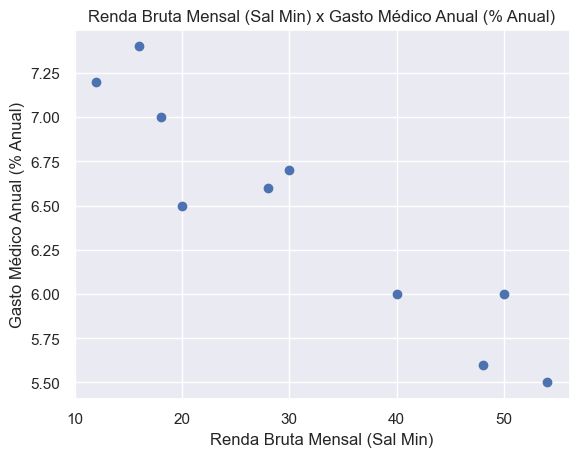

In [19]:
plt.scatter(df["Renda Bruta Mensal (Sal Min)"], df["Gasto Médico Anual (% Anual)"])
plt.title("Renda Bruta Mensal (Sal Min) x Gasto Médico Anual (% Anual)")
plt.xlabel("Renda Bruta Mensal (Sal Min)")
plt.ylabel("Gasto Médico Anual (% Anual)")
plt.show()

Oito indivíduos foram submetidos a um teste sobre conhecimento de língua estrangeira e, em seguida, mediu-se o tempo gasto para cada um aprender a operar uma determinada máquina.

In [20]:
individuos = ["A", "B", "C", "D", "E", "F", "G", "H"]
pontos_teste = [45, 52, 61, 70, 74, 76, 80, 90]
tempo_minutos = [343, 368, 355, 334, 337, 381, 345, 375]

df = pd.DataFrame(
    {
        "Indivíduos": individuos,
        "Pontos no Teste": pontos_teste,
        "Tempo (minutos)": tempo_minutos
    }
)
df = df.set_index("Indivíduos")
df

,Pontos no Teste,Tempo (minutos)
Indivíduos,,
A,45,343
B,52,368
C,61,355
D,70,334
E,74,337
F,76,381
G,80,345
H,90,375


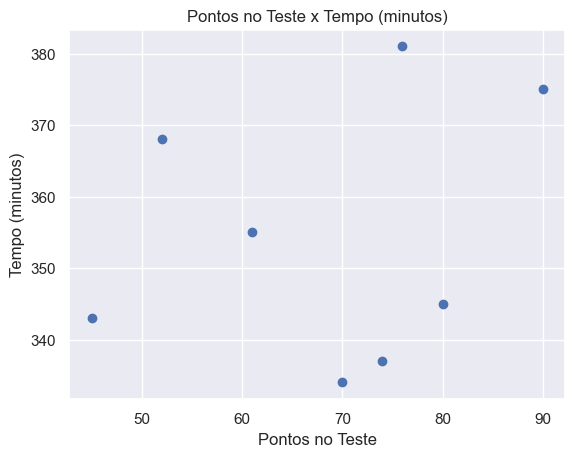

In [21]:
plt.scatter(df["Pontos no Teste"], df["Tempo (minutos)"])
plt.title("Pontos no Teste x Tempo (minutos)")
plt.xlabel("Pontos no Teste")
plt.ylabel("Tempo (minutos)")
plt.show()

In [22]:
df.corr()

,Pontos no Teste,Tempo (minutos)
Pontos no Teste,1.000000,0.238101
Tempo (minutos),0.238101,1.000000


In [7]:
def desvio_padrao(data):
    x_mean = data.mean()
    s = []
    for x in data:
        s.append((x - x_mean) ** 2)
    return sqrt(sum(s) / len(data))


In [8]:
df.columns

Index(['Anos de Serviço', 'Número de Clientes'], dtype='object')

In [9]:
x_mean = df["Anos de Serviço"].mean()
y_mean = df["Número de Clientes"].mean()
x_std = desvio_padrao(df["Anos de Serviço"])
y_std = desvio_padrao(df["Número de Clientes"])
n = df.shape[0]

In [10]:
df["x-x_mean"] = df["Anos de Serviço"] - x_mean
df["y-y_mean"] = df["Número de Clientes"] - y_mean
df["y-y_mean/dp(y)"] = df["y-y_mean"] / y_std
df["x-x_mean/dp(x)"] = df["x-x_mean"] / x_std
df["(x-x_mean/dp(x)) * (y-y_mean/dp(y))"] = df["x-x_mean/dp(x)"] * df["y-y_mean/dp(y)"]
df

,Anos de Serviço,Número de Clientes,x-x_mean,y-y_mean,y-y_mean/dp(y),x-x_mean/dp(x),(x-x_mean/dp(x)) * (y-y_mean/dp(y))
Agentes,,,,,,,
A,2,48,-3.7,-8.5,-1.047469,-1.535019,1.607884
B,3,50,-2.7,-6.5,-0.801005,-1.120149,0.897245
C,4,56,-1.7,-0.5,-0.061616,-0.705279,0.043456
D,5,52,-0.7,-4.5,-0.554542,-0.290409,0.161044
E,4,43,-1.7,-13.5,-1.663627,-0.705279,1.173321
F,6,60,0.3,3.5,0.431311,0.124461,0.053681
G,7,62,1.3,5.5,0.677774,0.539331,0.365544
H,8,58,2.3,1.5,0.184847,0.954201,0.176382
I,8,64,2.3,7.5,0.924237,0.954201,0.881908


In [11]:
(df["(x-x_mean/dp(x)) * (y-y_mean/dp(y))"].sum() / (n)) * 100

87.67952099440144

In [12]:
1/n * df["(x-x_mean/dp(x)) * (y-y_mean/dp(y))"].sum()

0.8767952099440145

In [13]:
((df["x-x_mean"] * df["y-y_mean"]).sum() / n) / (x_std * y_std)

0.8767952099440144

# Associação entre variáveis qualitativas e quantitativas

In [3]:
df.head()

,Estado Civil,Grau de Instrução,N de Filhos,Salario (x Sal Min),Anos,Meses,Região de Procedência
N,,,,,,,
1,solteiro,ensino fundamental,NaN,4.00,26,3,interior
2,casado,ensino fundamental,1.0,4.56,32,10,capital
3,casado,ensino fundamental,2.0,5.25,36,5,capital
4,solteiro,ensino médio,NaN,5.73,20,10,outra
5,solteiro,ensino fundamental,NaN,6.26,40,7,outra


In [8]:
def variancia(data):
    x_mean = data.mean()
    s = []
    for x in data:
        s.append((x - x_mean) ** 2)
    return sum(s) / len(data)

## Salários segundo grau de instrução

In [9]:
grau_instrucao = df["Grau de Instrução"].value_counts().reset_index().rename(columns={"index": "Grau de Instrução", "Grau de Instrução": "n"})
grau_instrucao_salario = grau_instrucao.merge(df.groupby("Grau de Instrução")["Salario (x Sal Min)"].mean().reset_index().rename(columns={"Salario (x Sal Min)": "mean(s)"}), on="Grau de Instrução")
grau_instrucao_salario.set_index("Grau de Instrução", inplace=True)
grau_instrucao_salario["dp(s)"] = df.groupby("Grau de Instrução")["Salario (x Sal Min)"].apply(lambda x: desvio_padrao(x))
grau_instrucao_salario["var(s)"] = df.groupby("Grau de Instrução")["Salario (x Sal Min)"].apply(lambda x: variancia(x))
grau_instrucao_salario["S(1)"] = df.groupby("Grau de Instrução")["Salario (x Sal Min)"].min()
grau_instrucao_salario["q1"] = df.groupby("Grau de Instrução")["Salario (x Sal Min)"].quantile(0.25)
grau_instrucao_salario["q2"] = df.groupby("Grau de Instrução")["Salario (x Sal Min)"].quantile(0.5)
grau_instrucao_salario["q3"] = df.groupby("Grau de Instrução")["Salario (x Sal Min)"].quantile(0.75)
grau_instrucao_salario["S(n)"] = df.groupby("Grau de Instrução")["Salario (x Sal Min)"].max()
grau_instrucao_salario

,n,mean(s),dp(s),var(s),S(1),q1,q2,q3,S(n)
Grau de Instrução,,,,,,,,,
ensino médio,18,11.528333,3.610471,13.035503,5.73,8.8375,10.910,14.4175,19.40
ensino fundamental,12,7.836667,2.830599,8.012289,4.00,6.0075,7.125,9.1625,13.85
superior,6,16.475000,4.110145,16.893292,10.53,13.6475,16.740,18.3775,23.30


<Axes: title={'center': 'Salários segundo grau de instrução'}, xlabel='Grau de Instrução', ylabel='Salario (x Sal Min)'>

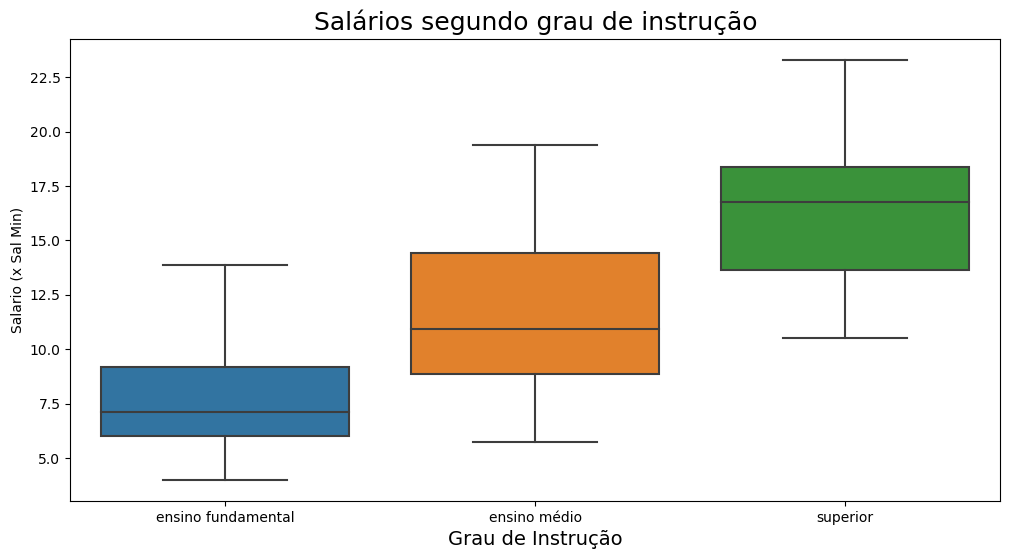

In [ ]:
ax = sns.boxplot(x = 'Grau de Instrução', y = 'Salario (x Sal Min)', data=df)
ax.figure.set_size_inches(12, 6)
ax.set_title('Salários segundo grau de instrução', fontsize = 18)
ax.set_xlabel('Grau de Instrução', fontsize = 14)
ax

## Salários segundo a região de procedência

In [ ]:
grau_instrucao = df["Região de Procedência"].value_counts().reset_index().rename(columns={"index": "Região de Procedência", "Região de Procedência": "n"})
grau_instrucao_salario = grau_instrucao.merge(df.groupby("Região de Procedência")["Salario (x Sal Min)"].mean().reset_index().rename(columns={"Salario (x Sal Min)": "mean(s)"}), on="Região de Procedência")
grau_instrucao_salario.set_index("Região de Procedência", inplace=True)
grau_instrucao_salario["dp(s)"] = df.groupby("Região de Procedência")["Salario (x Sal Min)"].apply(lambda x: desvio_padrao(x))
grau_instrucao_salario["var(s)"] = df.groupby("Região de Procedência")["Salario (x Sal Min)"].apply(lambda x: variancia(x))
grau_instrucao_salario["S(1)"] = df.groupby("Região de Procedência")["Salario (x Sal Min)"].min()
grau_instrucao_salario["q1"] = df.groupby("Região de Procedência")["Salario (x Sal Min)"].quantile(0.25)
grau_instrucao_salario["q2"] = df.groupby("Região de Procedência")["Salario (x Sal Min)"].quantile(0.5)
grau_instrucao_salario["q3"] = df.groupby("Região de Procedência")["Salario (x Sal Min)"].quantile(0.75)
grau_instrucao_salario["S(n)"] = df.groupby("Região de Procedência")["Salario (x Sal Min)"].max()
grau_instrucao_salario

,n,mean(s),dp(s),var(s),S(1),q1,q2,q3,S(n)
Região de Procedência,,,,,,,,,
outra,13,10.445385,3.022054,9.132809,5.73,8.740,9.800,12.790,16.22
interior,12,11.550000,5.070587,25.710850,4.00,7.805,10.645,14.695,23.30
capital,11,11.455455,5.221784,27.267025,4.56,7.490,9.770,16.625,19.40


<Axes: title={'center': 'Salários segundo grau de região de procedência'}, xlabel='Região de Procedência', ylabel='Salario (x Sal Min)'>

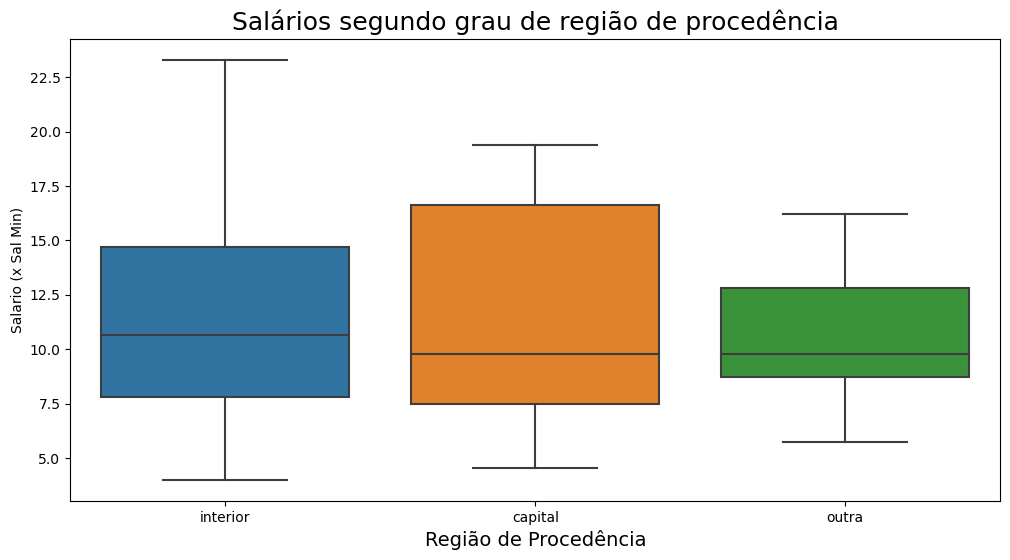

In [6]:
ax = sns.boxplot(x = 'Região de Procedência', y = 'Salario (x Sal Min)', data=df)
ax.figure.set_size_inches(12, 6)
ax.set_title('Salários segundo grau de região de procedência', fontsize = 18)
ax.set_xlabel('Região de Procedência', fontsize = 14)
ax

Variância Global

$$ \overline{var(S)} = \frac{\sum_{i=1}^k n_i \times var_j(S)}{\sum_{i=1}^k n_i} $$

In [20]:
global_var_s = df["Salario (x Sal Min)"].apply(lambda x: (x - df["Salario (x Sal Min)"].mean()) ** 2).sum() / df.shape[0]

In [21]:
var_s = sum([grau_instrucao_salario.loc[index, "n"] * grau_instrucao_salario.loc[index, "var(s)"] for index in grau_instrucao_salario.index]) / grau_instrucao_salario["n"].sum()

In [22]:
R2 = 1 - (var_s / global_var_s)
R2

0.41329658948948944

# Gráfico q x q

In [2]:
prova_1 = [8.5, 3.5, 7.2, 5.5, 9.5, 7.0, 4.8, 6.6, 2.5, 7.0, 7.4, 5.6, 6.3, 3.0, 8.1, 3.8, 6.8, 10.0, 4.5, 5.9]
prova_2 = [8.0, 2.8, 6.5, 6.2, 9.0, 7.5, 5.2, 7.2, 4.0, 4.8, 6.5, 5.0, 6.5, 3.0, 9.0, 4.0, 5.5, 10.0, 5.5, 5.0]

In [3]:
df = pd.DataFrame({"Prova 1": prova_1, "Prova 2": prova_2}, index=range(1, 21))
df.index.rename("Aluno", inplace=True)

In [4]:
df

,Prova 1,Prova 2
Aluno,,
1,8.5,8.0
2,3.5,2.8
3,7.2,6.5
4,5.5,6.2
5,9.5,9.0
6,7.0,7.5
7,4.8,5.2
8,6.6,7.2
9,2.5,4.0


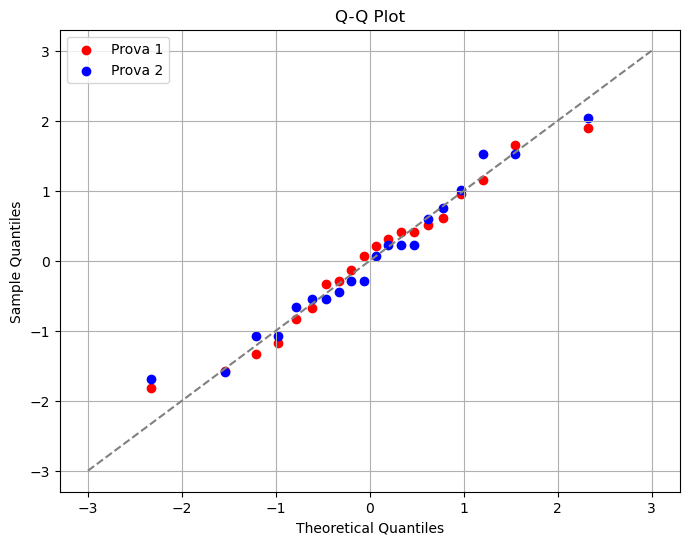

In [8]:
theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, num=len(prova_1)))

sorted_prova_1 = np.sort(prova_1)
sorted_prova_2 = np.sort(prova_2)

quantiles_prova_1 = stats.mstats.zscore(sorted_prova_1)
quantiles_prova_2 = stats.mstats.zscore(sorted_prova_2)


plt.figure(figsize=(8, 6))
plt.scatter(theoretical_quantiles, quantiles_prova_1, c='red', label='Prova 1')
plt.scatter(theoretical_quantiles, quantiles_prova_2, c='blue', label='Prova 2')
plt.plot([-3, 3], [-3, 3], '--', color='gray')  # Identity line
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.legend()
plt.title('Q-Q Plot')
plt.grid(True)
plt.show()

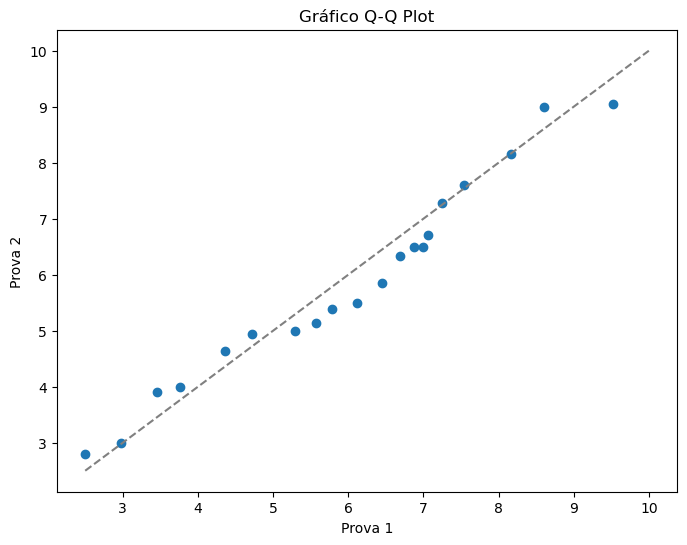

In [15]:
import matplotlib.pyplot as plt
import numpy as np

prova_1 = [8.5, 3.5, 7.2, 5.5, 9.5, 7.0, 4.8, 6.6, 2.5, 7.0, 7.4, 5.6, 6.3, 3.0, 8.1, 3.8, 6.8, 10.0, 4.5, 5.9]
prova_2 = [8.0, 2.8, 6.5, 6.2, 9.0, 7.5, 5.2, 7.2, 4.0, 4.8, 6.5, 5.0, 6.5, 3.0, 9.0, 4.0, 5.5, 10.0, 5.5, 5.0]

# Ordenar os dados em ordem crescente
prova_1.sort()
prova_2.sort()

# Calcular os quantis
quantis_1 = np.arange(0, 1, 1/len(prova_1))
quantis_2 = np.arange(0, 1, 1/len(prova_2))

# Gerar o gráfico Q-Q plot
plt.figure(figsize=(8, 6))
plt.scatter(np.quantile(prova_1, quantis_1), np.quantile(prova_2, quantis_2))
plt.plot([2.5, 10], [2.5, 10], '--', color='gray')  # Identity line
plt.xlabel('Prova 1')
plt.ylabel('Prova 2')
plt.title('Gráfico Q-Q Plot')
plt.show()


In [24]:
max([max(A), max(B)])

102

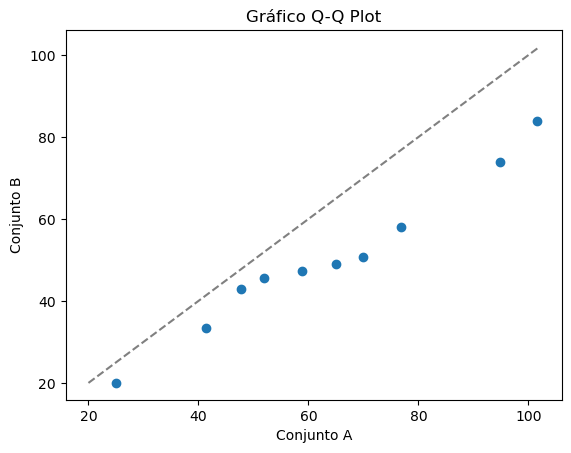

In [25]:
A = [65, 54, 49, 60, 70, 25, 87, 100, 70, 102, 40, 47]
B = [48, 35, 45, 50, 52, 20, 72, 102, 46, 82]

# Ordenar os dados em ordem crescente
A.sort()
B.sort()

min(A)

# Calcular os quantis
quantis_A = np.arange(0, 1, 1/len(A))
quantis_B = np.arange(0, 1, 1/len(B))

# Ajustar os quantis do conjunto menor
quantis_A_interp = np.interp(quantis_B, quantis_A, A)

# Gerar o gráfico Q-Q plot
plt.scatter(quantis_A_interp, np.quantile(B, quantis_B))
plt.plot([min([min(A), min(B)]), max([max(A), max(B)])], [min([min(A), min(B)]), max([max(A), max(B)])], '--', color='gray')  # Identity line
plt.xlabel('Conjunto A')
plt.ylabel('Conjunto B')
plt.title('Gráfico Q-Q Plot')
plt.show()